# LeNet-5模型的Python实现

本文基于Python的Tensorflow库实现了经典模型LeNet-5，并在数据集CIFAR-10上进行训练和测试。

## LeNet-5模型

LeNet-5模型是Yan Lecun在1998年提出的一种卷积神经网络模型，最初设计用于手写数字的识别，是早期卷积神经网络中最有代表性的实验系统之一。[论文原地址链接](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)。以下是该模型的结构。![lennet](https://img-blog.csdn.net/20171018154341615?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvaGFwcHlvcmc=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

## CIFAR-10数据集

CIOWE10数据集包括60000个32×32彩色图像，分为10个类别，每个类有6000个图像。有50000个训练图像和10000个测试图像。
数据集分为五个训练批次和一个测试批次，每一个批次都有10000个图像。测试批次包含来自每个类别的随机抽取的1000个图像。训练批次在剩余图像中随机抽取，训练批次可能包含某一类的图像多于另一类。训练批次包含来自每个类的5000个图像。
下面是数据集中的类别以及10个随机抽取的图像：
![](https://github.com/freefrog1986/Articles/blob/master/%E5%AE%9E%E7%8E%B0Lenet-5%E6%A8%A1%E5%9E%8B%E5%AF%B9CIFAR-10%E6%95%B0%E6%8D%AE%E9%9B%86%E8%BF%9B%E8%A1%8C%E5%88%86%E7%B1%BB/cifar-10.png?raw=true)

## 目标

本文的目标是搭建LeNet模型，并在CIFAR-10数据集上进行训练和测试。使用python语言和tensorflow库。为了方便处理数据集，请下载helper.py文件并放在你的工作目录下。[下载地址.](https://github.com/freefrog1986/Articles/tree/master/%E5%AE%9E%E7%8E%B0Lenet-5%E6%A8%A1%E5%9E%8B%E5%AF%B9CIFAR-10%E6%95%B0%E6%8D%AE%E9%9B%86%E8%BF%9B%E8%A1%8C%E5%88%86%E7%B1%BB)

- python 版本： Python '3.5.4'
- tensorflow 版本：tensorflow '1.1.0'

## 获取数据

数据集下载地址：[CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)
请下载并解压缩。

## 预处理函数

***归一化***

我们知道，图像大小为[32,32,3]，其中第三维代表RGB通道，每一个通道的取值范围是[0,255]，所以我们将每一个像素数据除以255，相当于对数据进行归一化处理，得到归一化之后的数据取值范围是[0, 1]。

In [19]:
def normalize(x):
    """
    归一化至范围[0, 1]
    x: 像素数据列表
    return: 归一化后的数据
    """
    return x/255 

In [20]:
import numpy as np
normalize(np.array([120,329,255])) #测试

array([0.47058824, 1.29019608, 1.        ])

***One-hot编码***

这里需要对标签进行one-hot编码，首先创建一个与类别数量相同的全0数组，然后将对应位置置为1。例如，编码前的标签是4，编码后为[0,0,0,1,0,0,0,0,0,0]

In [21]:
def one_hot_encode(x):
    """
    one-hot编码.
    : x: 标签列表
    : return: Numpy array格式的one-hot编码标签列表
    """
    output = np.zeros((len(x),10)) # 根据输入数组的长度和类别数量创建数组
    for i in range(len(x)):
        output[i][x[i]] = 1 # 将数组的对应位置置为1 
    return output

In [25]:
one_hot_encode(np.array([1,3,6,2,4,9])) #测试

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

## 对所有数据进行预处理并保存

有了上述预处理函数，我们就可以对所有数据进行预处理并保存。

In [35]:
# 这里需要下载helper.py，并保存在工作目录下，下载链接在“目标”章节
import helper
helper.preprocess_and_save_data('cifar-10-batches-py', normalize, one_hot_encode)

In [110]:
import pickle

# 读取保存的数据
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## 打造卷积网络基本模块

这一章主要聚焦打造卷积神经网络的基本模块，包括输入层，卷积层，池化层，全连接层，输出层等。使用tensorflow库。

***图像输入***

根据输入图像的尺寸定义tensor。

In [44]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    返回输入图像的tensor
    : image_shape: 图像的尺寸
    : return: 正确尺寸的Tensor
    """
    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], name = 'x')

In [45]:
neural_net_image_input([32, 32, 3]) #测试

<tf.Tensor 'x_4:0' shape=(?, 32, 32, 3) dtype=float32>

注意到，这里将[32, 32, 3]尺寸的图像转换为(?, 32, 32, 3)尺寸的tensor格式，第一个维度是‘？’，因为第一个维度代表批大小，这里可以使用问号来代表以后可以输入任意大小的批数量。

***标签输入***

根据输入标签的类别数量定义张量。

In [46]:
def neural_net_label_input(n_classes):
    """
    返回输入标签的tensor
    : n_classes: 标签类别数量
    : return: 正确尺寸的Tensor
    """
    return tf.placeholder(tf.float32, [None, n_classes], name = 'y')

In [47]:
neural_net_label_input(10) #测试

<tf.Tensor 'y:0' shape=(?, 10) dtype=float32>

返回的tensor尺寸为(?, 10)，问号代表后面可以输入任意大小的批数量。

***drop out参数***

后面会用到drop out算法，简单来说，这个算法通过在训练网络的过程中随机关闭一定比例的神经元来避免过拟合，所以这里需要设定一个参数，即随机关闭的比例keep_prob.

In [48]:
def neural_net_keep_prob_input():
    """
    返回tensor格式的概率，该概率是drop out算法的参数，表示保存的神经元的比例
    """
    return tf.placeholder(tf.float32, None, name = 'keep_prob')

***卷积和池化层***

观察LeNet-5结构: 输入层 -> 卷积层 -> 池化层 -> 卷积层 -> 池化层 -> 全连接层1 -> 全连接层2 -> 输出层

所以我们可以打造卷积-池化层模块和全连接层模块，将模块组合拼在一起即可以组成LeNet-5网络。

In [203]:
def conv2d_avgpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, keep_prob):
    """
    对输入x_tensor应用卷积层和池化层
    x_tensor: TensorFlow Tensor
    conv_num_outputs: 卷积层的输出数量
    conv_ksize: 卷积核的尺寸
    conv_strides: 卷积的步进
    pool_ksize: 池化层的核尺寸
    pool_strides: 池化层的步进
    keep_prob: dropout保存率
    : return: 经过卷积层和池化层后的tensor
    """
    weight = tf.Variable(tf.random_normal([conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[3],conv_num_outputs]))
    bias = tf.Variable(tf.random_normal([conv_num_outputs]))
    x = tf.nn.conv2d(x_tensor, weight, strides= [1,conv_strides[0],conv_strides[1],1], padding = 'VALID')
    x = tf.nn.bias_add(x, bias)
    x = tf.nn.dropout(x, keep_prob)
    x = tf.nn.avg_pool(x, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME') 
    x = tf.nn.sigmoid(x)
    return x

In [191]:
conv2d_avg_pool(tf.placeholder(tf.float32, [None, 32,32,3]), 6, (5,5), (1,1), (2,2), (2,2), 0.8) # 测试

<tf.Tensor 'MaxPool_2:0' shape=(?, 14, 14, 6) dtype=float32>

***Flatten层***

我们知道，全连接层就是常规神经网络中的隐藏层，它的维度是一维的，而卷积层和池化层处理的都是二维的数据，因此，池化层和全连接层之间有一个Flatten层将二维数据“Flatten”为一维数据。什么不将Flatten层定义为卷积神经网络中的一层，因为这一层没有任何参数，也没有对数据进行任何处理，所以我们可以把这层理解为对数据维度的一种转换，而不是神经网络最后中的一层。

In [192]:
import tensorflow.contrib as tfc
def flatten(x_tensor):
    """
    将x_tensor转换为(批大小, flatten后图像大小)
    x_tensor: 输入tensor
    return: 输出tensor
    """
    return tfc.layers.flatten(x_tensor)

In [193]:
flatten(tf.placeholder(tf.float32, [None, 16,16,10])) #测试

<tf.Tensor 'Flatten_1/Reshape:0' shape=(?, 2560) dtype=float32>

***全连接层***

全连接层相当于常规神经网络中的隐藏层，该层的唯一参数是输出尺寸（即神经元的数量）。

In [194]:
def fully_conn(x_tensor, num_outputs):
    """
    定义全连接层
    : x_tensor: 输入tensor
    : num_outputs: 输出尺寸
    : return: tensor
    """
    return tfc.layers.fully_connected(x_tensor, num_outputs)

In [195]:
fully_conn(tf.placeholder(tf.float32, [None, 2560]), 120) #测试

<tf.Tensor 'fully_connected_2/Relu:0' shape=(?, 120) dtype=float32>

***输出层***

最后是输出层，由于我们有10个类别，因此我们的输出层的尺寸为10.

In [196]:
def output(x_tensor, num_outputs):
    """
    定义输出层
    : x_tensor: 输入tensor
    : num_outputs: 输出尺寸
    : return: tensor
    """
    return tfc.layers.fully_connected(inputs = x_tensor, num_outputs = num_outputs, activation_fn=None)

In [197]:
output(tf.placeholder(tf.float32, [None, 120]), 10) #测试

<tf.Tensor 'fully_connected_3/BiasAdd:0' shape=(?, 10) dtype=float32>

***LeNet-5模型***

有了上述模块，接下来可以搭积木式搭建LeNet-5模型，为了方便，我们将该模型的结构图放在这里：![lennet](https://img-blog.csdn.net/20171018154341615?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvaGFwcHlvcmc=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

In [204]:
def LeNet(x, keep_prob):
    """
    打造LeNet
    : x: 输入tensor
    : keep_prob: dropout的保存率
    : return: Tensor
    """
    
    # C1 and S2 layer 
    x = conv2d_avgpool(x, 6, (5,5), (1,1), (2,2), (2,2), keep_prob)
    
    # C3 and S4 layer
    x = conv2d_avgpool(x, 16, (5,5), (1,1), (2,2), (2,2), keep_prob)
    
    # C5 layer
    weight = tf.Variable(tf.random_normal([5, 5, x.get_shape().as_list()[3],120]))
    bias = tf.Variable(tf.random_normal([120]))
    x = tf.nn.conv2d(x, weight, strides= [1,5,5,1], padding = 'VALID')
    x = tf.nn.bias_add(x, bias)
    x = flatten(x)
    
    # F6 layer
    x= fully_conn(x, 84)
    
    # ouput layer
    x = output(x, 10)

    return x

下面利用前面的模块构建模型，并定义损失函数和优化器。

In [205]:
tf.reset_default_graph()

# 输入
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# 模型
logits = LeNet(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# 损失函数和优化器
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# 使用准确率作为meritc
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### 训练神经网络

***训练函数***

因为我们要批量训练，所以这里我们先定义一个训练函数。

In [206]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    对批次训练集进行训练
    : session: TensorFlow session
    : optimizer: 优化器
    : keep_probability: dropout参数
    : feature_batch: 特征批次
    : label_batch: 标签批次
    """
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})
    pass

***打印状态***

由于训练时间较长，这里定义一个函数用于打印中间状态。

In [207]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    打印损失函数和准确率
    : session: TensorFlow session
    : feature_batch: 特征批次
    : label_batch: 标签批次
    : cost: 损失函数
    : accuracy: 精确度
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
    print(loss)
    print(valid_acc)
    pass

***训练***

In [209]:
epochs = 30
batch_size = 128
keep_probability = 0.9

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  2.3937168
0.1986
Epoch  1, CIFAR-10 Batch 2:  2.138945
0.2454
Epoch  1, CIFAR-10 Batch 3:  1.7392156
0.2046
Epoch  1, CIFAR-10 Batch 4:  2.077188
0.2468
Epoch  1, CIFAR-10 Batch 5:  2.2822495
0.2606
Epoch  2, CIFAR-10 Batch 1:  2.095818
0.2748
Epoch  2, CIFAR-10 Batch 2:  1.9870247
0.2902
Epoch  2, CIFAR-10 Batch 3:  1.5699615
0.2686
Epoch  2, CIFAR-10 Batch 4:  1.8418477
0.2838
Epoch  2, CIFAR-10 Batch 5:  2.1720307
0.303
Epoch  3, CIFAR-10 Batch 1:  1.984391
0.328
Epoch  3, CIFAR-10 Batch 2:  1.9639237
0.331
Epoch  3, CIFAR-10 Batch 3:  1.5062636
0.3034
Epoch  3, CIFAR-10 Batch 4:  1.6582733
0.3416
Epoch  3, CIFAR-10 Batch 5:  2.055703
0.3492
Epoch  4, CIFAR-10 Batch 1:  1.9153427
0.358
Epoch  4, CIFAR-10 Batch 2:  1.9415958
0.356
Epoch  4, CIFAR-10 Batch 3:  1.4535301
0.323
Epoch  4, CIFAR-10 Batch 4:  1.5730636
0.375
Epoch  4, CIFAR-10 Batch 5:  2.0198524
0.3744
Epoch  5, CIFAR-10 Batch 1:  1.8876024
0.3716
Epoch  5, CIFAR-10 Batch 2:  1.845

最终得到的准确率48.9%

## 测试

最后，在测试集上验证算法。

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.49238528481012656



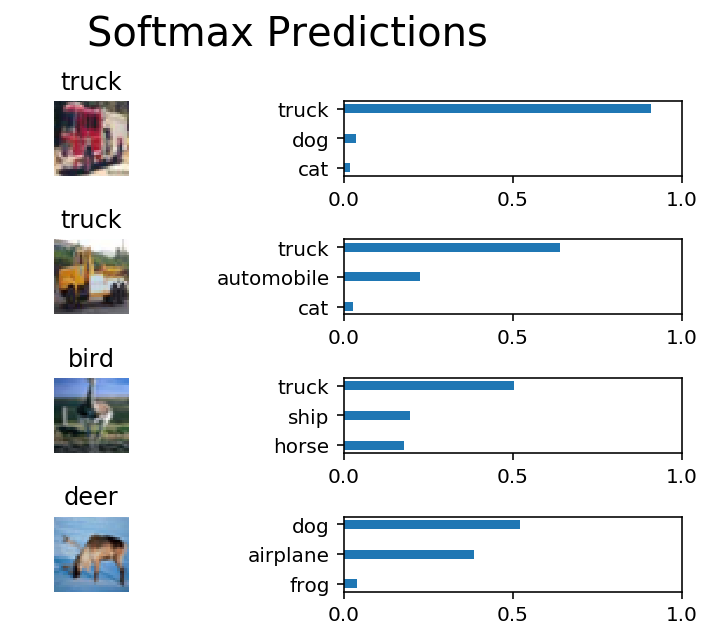

In [210]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()